## 네이버 영화평 감성 분석

In [57]:
from requests import put
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec

**데이터 로드**

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


: DataFrame로 변환 후 데이터 확인

### 데이터 전처리

**1.중복체크 및 결측치(NaN) 제거 및 데이터 정제**

In [3]:
# nunique() 함수를 이용한 고유 값 개수 체크
print(train_data['document'].nunique())
print(train_data['label'].nunique())

# document 컬럼의 중복 값 제거 
train_data.drop_duplicates(subset=['document'], inplace=True)

146182
2


In [4]:
# 결측치 카운팅
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [5]:
# 결측치 제거
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


* document = 146182개의 고유 값 존재
* lable = 2개의 고유 값 존재 (0 ,1)
* document의 결측치 1개 제거

In [6]:
# 한글을 제외한 문자 제거(숫자, 특수 문자 등)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")

train_data.head(8)

/tmp/ipykernel_603/720607363.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0


: ㅋㅋㅋ, ㅎㅎㅎ 등은 남길 필요성이 있음.

In [7]:
# null 값 지정 후 null 값 조회
train_data['document'].replace('', np.nan, inplace=True)
print(len(train_data))
print(train_data.isnull().sum())

146182
id            0
document    391
label         0
dtype: int64


In [8]:
train_data = train_data.dropna(how='any')
print(len(train_data))

145791


: 정규표현식으로 제거 후 아무것도 남지 않은 데이터 발생, 그 값을 null로 전환 후 null값 제거 <br/>
기존 146182개의 데이터에서 -> 145791개로 축소됨.

test data도 train data와 똑같이 적용

In [9]:
test_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "") # 한글 제외한 숫자 및 특수문자 제거
test_data['document'].replace('', np.nan, inplace=True) # 공백 결측치로 변환
test_data = test_data.dropna(how='any') # 다시 결측치 제거

/tmp/ipykernel_603/2763084999.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "") # 한글 제외한 숫자 및 특수문자 제거


**2.불용어 제거 및 토큰화**

In [10]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

**4.텍스트 스트링을 사전 인덱스 스트링으로 변환**

In [11]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [12]:
len(word_to_index)

10000

In [13]:
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3, '영화': 4, '다': 5, '고': 6, '하': 7, '을': 8, '보': 9, '게': 10, '지': 11, '있': 12, '없': 13, '좋': 14, '나': 15, '었': 16, '만': 17, '는데': 18, '너무': 19, '봤': 20, '적': 21, '안': 22, '정말': 23, '로': 24, '것': 25, '음': 26, '아': 27, '네요': 28, '어': 29, '지만': 30, '재밌': 31, '같': 32, '진짜': 33, '에서': 34, '했': 35, '기': 36, '네': 37, '않': 38, '거': 39, '점': 40, '았': 41, '수': 42, '되': 43, '면': 44, 'ㅋㅋ': 45, '인': 46, '연기': 47, '말': 48, '주': 49, '내': 50, '평점': 51, '최고': 52, '이런': 53, '던': 54, '어요': 55, '할': 56, '왜': 57, '겠': 58, '스토리': 59, 'ㅋㅋㅋ': 60, '해': 61, '습니다': 62, '듯': 63, '아니': 64, '생각': 65, '드라마': 66, '더': 67, '그': 68, '사람': 69, '싶': 70, '때': 71, '감동': 72, '배우': 73, '함': 74, '본': 75, '까지': 76, '알': 77, '만들': 78, '뭐': 79, '내용': 80, '볼': 81, '보다': 82, '감독': 83, '라': 84, '그냥': 85, '재미': 86, '시간': 87, '지루': 88, '중': 89, '재미있': 90, '였': 91, '년': 92, '잼': 93, '사랑': 94, '못': 95, '냐': 96, '쓰레기': 97, '재미없': 98, '서': 99, '라고': 100, '니': 101, '면서': 102, '다시': 103, '번'

In [14]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
        return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

**5.빈도 수 낮은 단어 체크**
- 빈도 수가 낮은 단어는 학습에 영향을 주지 않음.

In [15]:
threshold = 3
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_to_index.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10000
등장 빈도가 2번 이하인 희귀 단어의 수: 3
단어 집합에서 희귀 단어의 비율: 0.03
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.000600060006001e-06


**6.패딩 작업**
- 모델 입력을 위해 동일한 길이로 맞춤.
- 리뷰의 전반적인 길이 확인

In [16]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.922107465980906
문장길이 최대 :  83
문장길이 표준편차 :  11.45538205199436


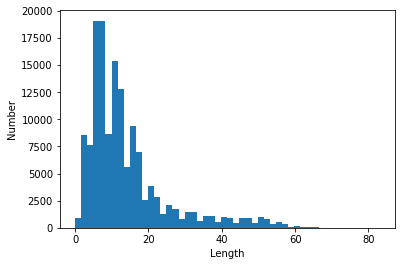

In [17]:
plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('Length')
plt.ylabel('Number')
plt.show()

In [18]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  36
전체 문장의 0.9328884215348416%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
# maxlen 36으로 패딩 작업

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)
print(X_train.shape)
print(X_test.shape)

(143681, 36)
(48417, 36)


**7.검증 데이터셋 분리**

In [20]:
# validation set 25000건 분리
x_val = X_train[:25000]   
y_val = y_train[:25000]

# validation set을 제외한 나머지
partial_X_train = X_train[25000:]  
partial_y_train = y_train[25000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(118681, 36)
(118681,)


### 모델 구축 및 학습

**1.LSTM**

**모델 설계**

In [21]:
vocab_size = 10000
word_vector_dim = 100

LSTM = keras.Sequential()
LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM.add(keras.layers.LSTM(128))
LSTM.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM.compile(optimizer='rmsprop',
            loss = 'binary_crossentropy',
            metrics=['acc'])

LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


**학습**

In [22]:
epochs = 9
history = LSTM.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=60,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/9
1979/1979 [==============================] - 15s 6ms/step - loss: 0.3897 - acc: 0.8229 - val_loss: 0.3431 - val_acc: 0.8468
Epoch 2/9
1979/1979 [==============================] - 11s 5ms/step - loss: 0.3244 - acc: 0.8593 - val_loss: 0.3274 - val_acc: 0.8560
Epoch 3/9
1979/1979 [==============================] - 11s 6ms/step - loss: 0.3004 - acc: 0.8727 - val_loss: 0.3280 - val_acc: 0.8584
Epoch 4/9
1979/1979 [==============================] - 11s 6ms/step - loss: 0.2837 - acc: 0.8811 - val_loss: 0.3182 - val_acc: 0.8611
Epoch 5/9
1979/1979 [==============================] - 11s 6ms/step - loss: 0.2706 - acc: 0.8874 - val_loss: 0.3103 - val_acc: 0.8644
Epoch 6/9
1979/1979 [==============================] - 11s 6ms/step - loss: 0.2592 - acc: 0.8935 - val_loss: 0.3268 - val_acc: 0.8592
Epoch 7/9
1979/1979 [==============================] - 11s 6ms/step - loss: 0.2462 - acc: 0.8994 - val_loss: 0.3177 - val_acc: 0.8628
Epoch 8/9
1979/1979 [==============================] - 11s 6ms

In [23]:
LSTM.evaluate(X_test, y_test)

1514/1514 [==============================] - 4s 3ms/step - loss: 0.3417 - acc: 0.8623


[0.3417190611362457, 0.8622797727584839]

**시각화**

In [24]:
LSTM_history_dict = history.history

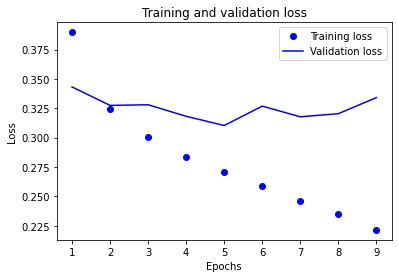

In [25]:
acc = LSTM_history_dict['acc']
val_acc = LSTM_history_dict['val_acc']
loss = LSTM_history_dict['loss']
val_loss = LSTM_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

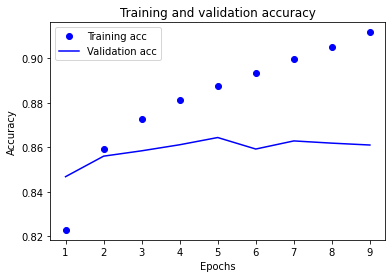

In [26]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**2.Word2Vec**

In [27]:
embedding_layer = LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 100)


In [28]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/LSTMword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['행복']
vector

array([-0.1459795 , -0.14447829,  0.52175266, -0.42709905, -0.33199564,
        0.6898673 , -0.22154205,  0.93616533, -0.17667602, -0.25503045,
        0.36904722, -0.19328544,  0.18458232,  0.15800767,  0.52036124,
        0.3149744 ,  0.59639895, -0.34976938, -0.12465806,  0.28535062,
       -0.678983  ,  0.01566155,  0.2402242 ,  0.2688037 , -0.25121996,
        0.5748643 , -0.03352603,  0.5022203 , -0.40374064, -0.2555499 ,
        0.39755514,  0.07863808,  0.3358279 , -0.03983373,  0.03760784,
       -0.42895427, -0.3011878 , -0.11916961, -0.6676474 ,  0.27048853,
        0.048323  , -0.5825535 ,  0.3342966 ,  0.2618499 ,  0.3960313 ,
       -0.02285364, -0.66285056,  0.35645562, -0.21532178,  0.2375133 ,
        0.19250439,  0.27989045,  0.21413478, -0.13238531,  0.23893708,
       -0.6729929 , -0.29837888,  0.14631373,  0.45158404,  0.191456  ,
        0.39410207,  0.30281988,  0.0187124 ,  0.19065484,  0.21446098,
        1.0080473 ,  0.44131154,  0.03798798, -0.21466906, -0.16

In [30]:
word_vectors.similar_by_word("행복")

[('아련', 0.9573794603347778),
 ('소장', 0.9506902694702148),
 ('훈훈', 0.9475509524345398),
 ('울', 0.9425837993621826),
 ('영원', 0.941347062587738),
 ('강렬', 0.940165102481842),
 ('통쾌', 0.9390749335289001),
 ('찡', 0.9341318011283875),
 ('힐링', 0.9211065769195557),
 ('눈물', 0.9196282029151917)]

In [61]:
word2vec_path = os.getenv('HOME')+'/aiffel/exploration/miniproject/Ex06/ko.bin'
word2vec =gensim.models.Word2Vec.load(word2vec_path)
#vector = word2vec['컴퓨터']
#vector     

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

In [60]:
# 임베딩 레이어를 Word2Vec으로 교체 후 다시 학습
vocab_size = 10000
word_vector_dim = 300

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

NameError: name 'word2vec' is not defined

## 회고

In [ ]:
if word in self.w2v_model.wv:
    vector = self.w2v_model.wv[word]
else:
    vector = [0] * 100

$ pip install --upgrade gensim==3.8.3

word2vec도 사용하여 학습을 진행하고 싶었지만, 오류를 잡을 수 없어 lstm 모델로 진행된 것만 회고를 남깁니다. <br/>
LSTM 모델 성능은 0.86으로 제법 준수하게 나온거 같으나 word2vec로 학습을 진행하지 못했던 점이 너무 아쉽습니다. <br/>
모델을 학습시키기위해 전처리 모델 설계 학습 시각화등 다양한 요소도 중요하지만 개발 환경 설정을 맞추는 것도 크게 한 몫 한다는 것을 느꼈습니다. 